# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
data[data['Survived']==1].Sex.value_counts()

female    233
male      109
Name: Sex, dtype: int64

In [8]:
# 0 for males, 1 for females
data['Sex_binary']=(1*(data.Sex=='female'))
data[['Survived', 'Sex_binary']].corr()

,Survived,Sex_binary
Survived,1.000000,0.543351
Sex_binary,0.543351,1.000000


< your thoughts >
Наблюдается заметная, но не высокая корреляция между тем, является ли пассажир женщиной и является ли он выжившим. Это можно объяснит тем, что спасались в первую очередь женщины, но имеют место быть также и иные факторы.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

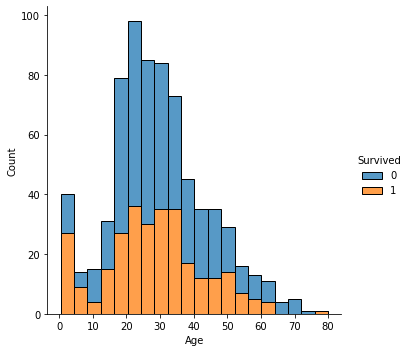

In [51]:
sns.displot(data, x='Age', hue='Survived', multiple='stack')

In [10]:
print(f'Median age of survived pass-s  is {data[data.Survived==1].Age.median()}')
print(f'Average age of survived pass-s is {data[data.Survived==1].Age.mean()}')
print(f'Median age of deceased pass-s  is {data[data.Survived==0].Age.median()}')
print(f'Average age of deceased pass-s is {data[data.Survived==0].Age.mean()}')

Median age of survived pass-s  is 28.0
Average age of survived pass-s is 28.343689655172415
Median age of deceased pass-s  is 28.0
Average age of deceased pass-s is 30.62617924528302


< your thoughts >
Разительно распределение выживших/не выживших по возрасту не отличаются. Можно заметить, что лица до 10 лет в подавляющем большинстве своем спаслись - детей спасают первыми всегда. Далее видно, что доля выживших на процентов 10-20 ниже среди взрослого населения - здесь уже при спасении большую роль, думаю, начинает играть класс. 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

< your thoughts >

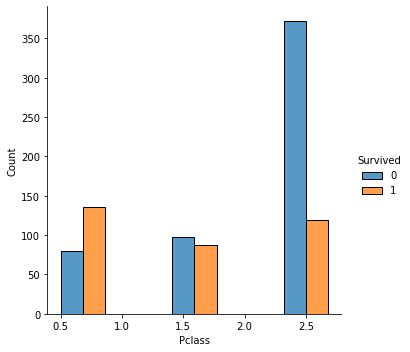

In [11]:
sns.displot(data, x='Pclass', hue='Survived', multiple='dodge', shrink=2)#bins=[1,2,3,4])

Видно, что в среднем шансы спастись были выше у пассажиров в первом классе, во втором классе шансы на спасение или смерть были одинаковы, а в третьем классе вероятность умереть гораздо выше. Это можно объяснить так: сначала шлюпки предоставлялись дамам и детям из первого класса, затем дамам и детям из второго, затем джентльменам из первого класса - и вот тут начинается нехватка шлюпок (вызванная нерациональным их распределением) или "борьба" за них.

In [12]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

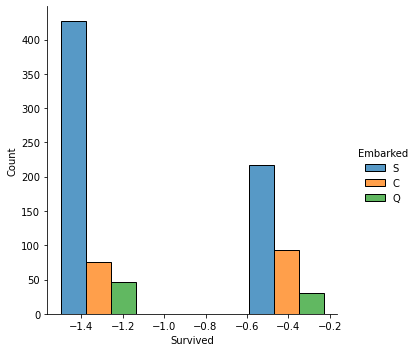

In [13]:
sns.displot(data, x='Survived', hue='Embarked', multiple='dodge', shrink=4)
#Слева - те, кто не выжил, справа - выжившие

Видно, что те пассажиры, что погружались на корабль в порту S, в 2 раза чаще погибали, но пассажиров из этгоо порта было больше всего. Скорее всего, это были в основном пассажиры из третьего класса.
Пассажиры из порта C выживали несколько чаще - скорее всего, это пассажиры из первого класса в основном (или наоборот - пассажиры из первого класса были в основном из этого порта)
Пассажиры из порта Q выживали раза в два реже, но их мало. Возможно, из этого порта были в равной пропорции (+-) пассажиры всех классов.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [14]:
data.isna().mean()

Survived      0.000000
Pclass        0.000000
Name          0.000000
Sex           0.000000
Age           0.198653
SibSp         0.000000
Parch         0.000000
Ticket        0.000000
Fare          0.000000
Cabin         0.771044
Embarked      0.002245
Sex_binary    0.000000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >
Номер каюты вообще роли не играет, разве что мы не удем рассматривать карту корабля и рассчитывать шансы на спасение. Тут нужно подумать, а было ли большинство пассажиров из тех или иных классов в своих каютах. Можно на основании этих мыслей либо заменить их медианными значениями, либо вообще не рассматривать эту колонку.
Возраст можно заменить медианными значениями
Embarked можно заменить медианным значением или выбросить те записи, где он отсутствует.
drop - сохраняет распределение
mean/median - изменяет распределение, уменьшает разброс

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

### Перекодируем порт посадки

In [111]:
data['Embarked_S'] = 1*(data['Embarked']=='S')
data['Embarked_C'] = 1*(data['Embarked']=='C')
data['Embarked_Q'] = 1*(data['Embarked']=='Q')

In [164]:
actual_features=['Pclass', 'Sex_binary', 'Age', 'Fare', 'Embarked_S', 'Embarked_C']
data[actual_features]

,Pclass,Sex_binary,Age,Fare,Embarked_S,Embarked_C
PassengerId,,,,,,
1,3,0,22.0,7.2500,1,0
2,1,1,38.0,71.2833,0,1
3,3,1,26.0,7.9250,1,0
4,1,1,35.0,53.1000,1,0
5,3,0,35.0,8.0500,1,0
...,...,...,...,...,...,...
887,2,0,27.0,13.0000,1,0
888,1,1,19.0,30.0000,1,0
889,3,1,NaN,23.4500,1,0


### Восстановим данные

In [165]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(max_iter = 10, random_state=0)

In [166]:
imputer.fit(data[actual_features])
restored_data = pd.DataFrame(imputer.transform(data[actual_features]), columns=actual_features, index=data.index)
restored_data['Survived']=data['Survived']

### Займемся масштабированием признаков

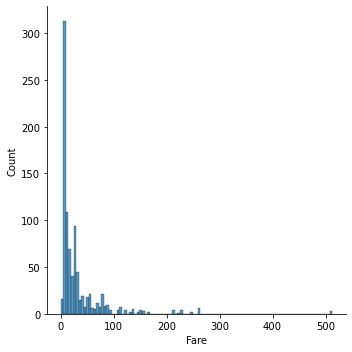

In [167]:
scaled_restored_data = restored_data.copy()
sns.displot(restored_data, x='Fare')

Видно, что распределение платы за билет - лог-нормальнoe

In [168]:
#тк выше мы именно восстанавливали данные, то могли появиться фантастические показатели в Fare
restored_data.loc[restored_data[restored_data.Fare<1].index]=1

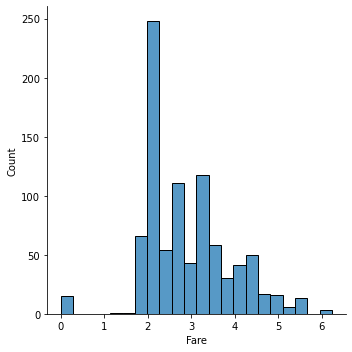

In [169]:
scaled_restored_data['Fare'] = np.log(restored_data.Fare)
sns.displot(scaled_restored_data, x='Fare')

In [170]:
#Масштабируем этот признак minMaxScaler-м
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()

In [171]:
features_to_be_minMax_scaled = ['Fare']
minMaxScaler.fit(scaled_restored_data[features_to_be_minMax_scaled])
scaled_features = minMaxScaler.transform(scaled_restored_data[features_to_be_minMax_scaled])

for i in range(0, len(features_to_be_minMax_scaled)):
    scaled_restored_data[features_to_be_minMax_scaled[i]] = scaled_features[:,i]
scaled_restored_data

,Pclass,Sex_binary,Age,Fare,Embarked_S,Embarked_C,Survived
PassengerId,,,,,,,
1,3.0,0.0,22.000000,0.317521,1.0,0.0,0
2,1.0,1.0,38.000000,0.683873,0.0,1.0,1
3,3.0,1.0,26.000000,0.331789,1.0,0.0,1
4,1.0,1.0,35.000000,0.636672,1.0,0.0,1
5,3.0,0.0,35.000000,0.334298,1.0,0.0,0
...,...,...,...,...,...,...,...
887,2.0,0.0,27.000000,0.411118,1.0,0.0,0
888,1.0,1.0,19.000000,0.545154,1.0,0.0,1
889,3.0,1.0,21.560809,0.505672,1.0,0.0,0


Возраст распределен нормально, поэтому применим StandardScaler

In [172]:
stdScaler = StandardScaler()
stdScaler.fit(restored_data[['Age']])
scaled_restored_data['Age'] = stdScaler.transform(restored_data[['Age']])
scaled_restored_data

,Pclass,Sex_binary,Age,Fare,Embarked_S,Embarked_C,Survived
PassengerId,,,,,,,
1,3.0,0.0,-0.492718,0.317521,1.0,0.0,0
2,1.0,1.0,0.675249,0.683873,0.0,1.0,1
3,3.0,1.0,-0.200727,0.331789,1.0,0.0,1
4,1.0,1.0,0.456255,0.636672,1.0,0.0,1
5,3.0,0.0,0.456255,0.334298,1.0,0.0,0
...,...,...,...,...,...,...,...
887,2.0,0.0,-0.127729,0.411118,1.0,0.0,0
888,1.0,1.0,-0.711712,0.545154,1.0,0.0,1
889,3.0,1.0,-0.524779,0.505672,1.0,0.0,0


### Перекодируем Класс, тк информация о втором классе захламляет модель - в нем равновероятно можно умереть или спастись

Pclass       -0.338481
Embarked_S   -0.155660
Age          -0.030727
Embarked_C    0.168240
Fare          0.331805
Feat_1        0.510819
Sex_binary    0.543351
Survived      1.000000
Name: Survived, dtype: float64

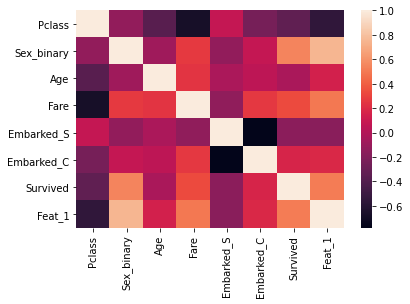

In [189]:
#scaled_restored_data['Class_1'] = 1*(data['Pclass']==1)
#scaled_restored_data['Class_3'] = 1*(data['Pclass']==3)
scaled_restored_data['Feat_1'] = 1*((data['Pclass']==1) | (data['Sex_binary']==1))
actual_features = ['Sex_binary', 'Age', 'Fare', 'Embarked_S', 'Embarked_C', 'Feat_1']
sns.heatmap(scaled_restored_data.corr())
scaled_restored_data.corr().Survived.sort_values()

## Теперь моделируем

In [190]:
#actual_features=['Age', 'Fare']
y= scaled_restored_data['Survived']

####scaled_restored_data['Age'] = 1*(scaled_restored_data['Age']<=6)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)

In [191]:
X = scaled_restored_data[actual_features]
knn.fit(X,y)
knn.score(X,y)

0.8731762065095399

In [193]:
logreg= LogisticRegression()
cross_val_score(logreg, scaled_restored_data, y, 
                      scoring='accuracy', cv=5).mean()

1.0

In [194]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

test_data['Sex_binary']=(1*(test_data.Sex=='female'))
test_data['Embarked_S'] = 1*(test_data['Embarked']=='S')
test_data['Embarked_C'] = 1*(test_data['Embarked']=='C')
test_data['Embarked_Q'] = 1*(test_data['Embarked']=='Q')
#test_data['Class_1'] = 1*(test_data['Pclass']==1)
#test_data['Class_3'] = 1*(test_data['Pclass']==3)

test_imputer = IterativeImputer(max_iter = 10, random_state=0)
test_imputer.fit(test_data[actual_features])
test_data = pd.DataFrame(test_imputer.transform(test_data[actual_features]), columns=actual_features, index=test_data.index)

scaled_test_data= test_data.copy()
#могли быть при восстановлении получены фантастические ценники в Fare или они изначально были нулевые
test_data[test_data.Fare<1]=1
scaled_test_data['Fare'] = np.log(test_data.Fare)

test_scaled_features = minMaxScaler.transform(scaled_test_data[features_to_be_minMax_scaled])
for i in range(0, len(features_to_be_minMax_scaled)):
    scaled_test_data[features_to_be_minMax_scaled[i]] = test_scaled_features[:,i]

scaled_test_data['Age'] = stdScaler.transform(test_data[['Age']])

KeyError: "['Feat_1'] not in index"

In [178]:
predicted_test_data = test_data.copy()
predicted_test_data['Survived'] = knn.predict(X=scaled_test_data[actual_features])

In [179]:
predicted_test_data[['Survived']].to_csv('my_predictions.csv', index=True)
predicted_test_data[['Survived']]

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [31]:
## your code

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [32]:
## your code

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [33]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

FileNotFoundError: [Errno 2] No such file or directory: './data/porto\\train.csv'

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code